In [4]:
from rixs import *
from calibration import *
import json
%load_ext autoreload
%autoreload 2

In [5]:
alexis_directory = '/home/amouretti/XRTS_2025/fssr_analysis'

cal_alexis = SpectrometerRIXS(
    base_path=alexis_directory,
    fssr_name="fssr2"
)

Using existing directory: /home/amouretti/XRTS_2025/fssr_analysis/fssr2/tif


Filtering using (summed mean + 4 * std deviation)
Hot pixels detected: 1429


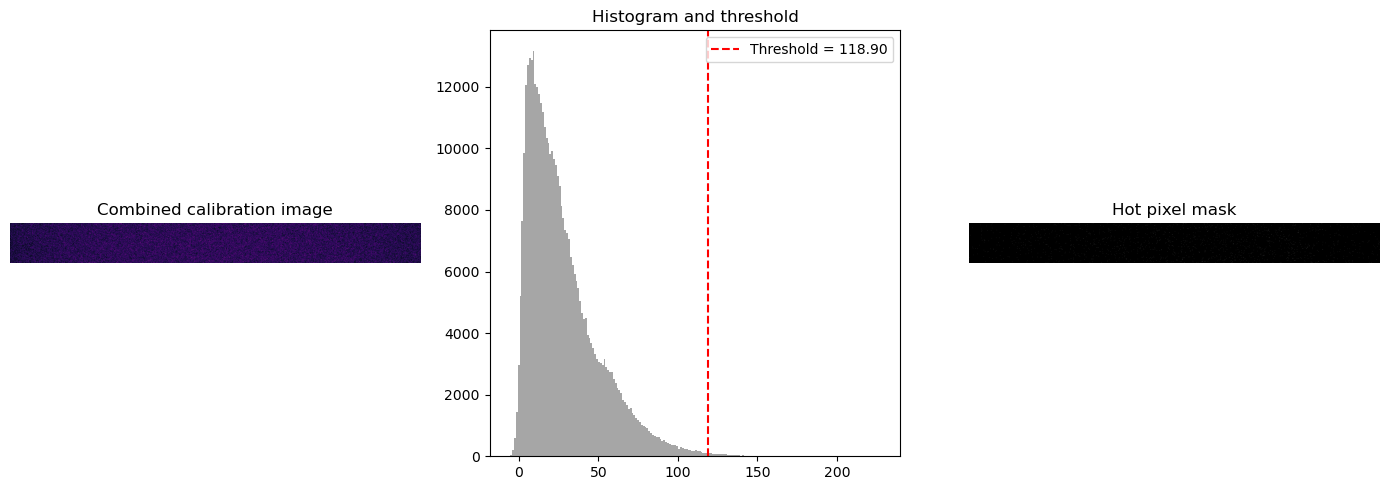

In [7]:
# Create hot pixel mask from runs
run_list = [1550331, 1550329, 1550333]
darkrunNo = 1549800
hotpixelmask = cal_alexis.create_hotpixel_mask(runs=run_list, dark_run=darkrunNo, n_dark=10, use_otsu=False, mean=True, plot=True)

In [8]:
# If happy, save the hot pixel mask
save_path = '/home/fitzgerald/rixs'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    print("Oops, your save path didn't exist - new path created!")
    
hotpixelmask_savepath = os.path.join(save_path, 'hotpixelmask.npy')
np.save(hotpixelmask_savepath, hotpixelmask)

Oops, your save path didn't exist - new path created!


In [11]:
cal = SpectrometerRIXS(
    base_path="/home/fitzgerald/RIXS_25/rixs",
    fssr_name="fssr1"
)

Using existing directory: /home/fitzgerald/RIXS_25/rixs/fssr1/tif


✅ Loaded and summed 3 runs for fssr1.


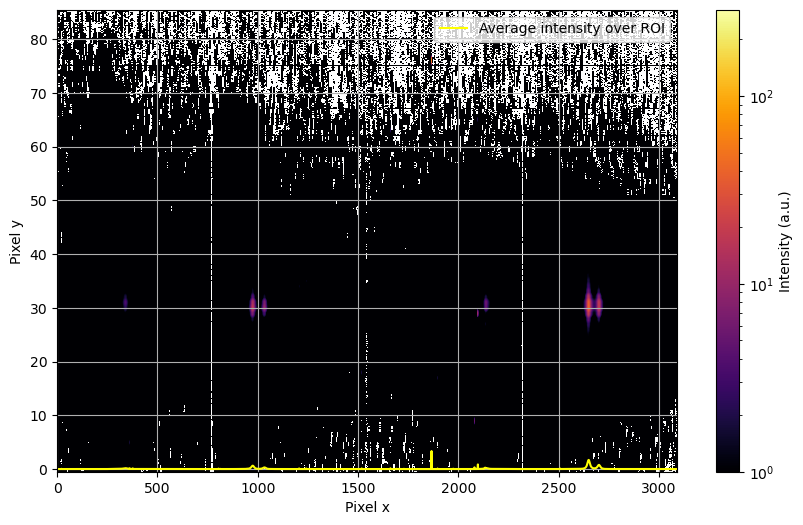

In [12]:
# test runs from the EUXFEL spectrometers, where 1540 is Co, 1541 is Cu, and 1542 is Ni
cal.load_images(runs=[1540, 1541, 1542], dark_run=None, n_dark=1, hotpixelmask_filepath = None, mean=True, plot=True)

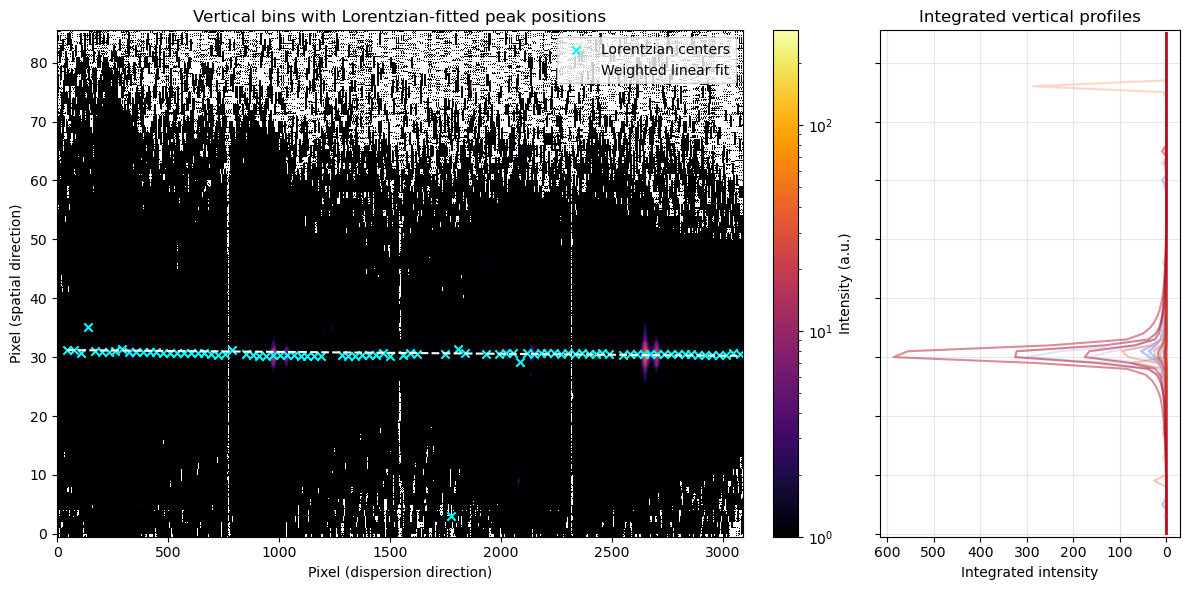

Weighted fit: y = -0.0003 * x + 31.21


In [13]:
# Stores: self.peak_positions, self.peak_amplitudes, self.fit_coeffs (where slope, intercept = coeffs)
cal.find_vertical_peaks_and_fit(n_bins=100, plot=True)

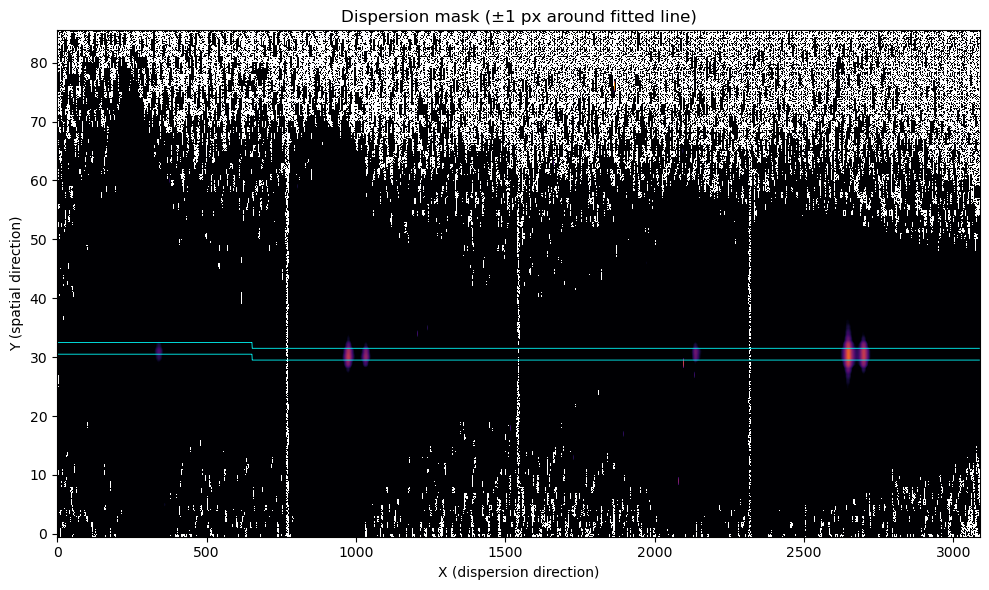

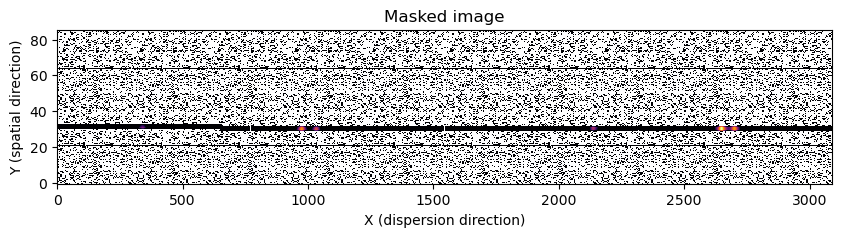

Created dispersion mask ±1 pixels wide around fitted line.


In [14]:
dispersion_mask = cal.generate_dispersion_axis_mask(width=1, plot=True)

In [15]:
# If happy, save the dispersion pixel mask
dispersionmask_savepath = os.path.join(save_path, 'dispersionmask.npy')
np.save(dispersionmask_savepath, dispersion_mask)

In [16]:
# Look-up table - capable of parsing strings such as "Fe2O3". NOTE: relative intensity is a naive approximation
df = get_emission_lines_lookup("Fe", incident_energy_keV=7.2)
print(df)

  Element Line  Energy_keV  RelIntensity
0      Fe  Ka2     6.39084      1.000000
1      Fe  Ka1     6.40384      0.999235
2      Fe  Kb1     7.05798      0.963313


In [17]:
# Testcase from EUXFEL spectrometers uses Ni, Co, Cu, can make a dictionary with all by parsing "NiCoCu"
df = get_emission_lines_lookup("NiCoCu", incident_energy_keV=8.38)
print(df)

  Element Line  Energy_keV  RelIntensity
0      Co  Ka2     6.91539      1.000000
1      Co  Ka1     6.93032      0.999189
2      Ni  Ka2     7.46089      0.971826
3      Ni  Ka1     7.47815      0.970981
4      Co  Kb1     7.64943      0.962739
5      Cu  Ka2     8.02800      0.945390
6      Cu  Ka1     8.04800      0.944504
7      Ni  Kb1     8.26466      0.935104


In [18]:
peakenergies_array = df[df["Energy_keV"] > 7.46]
print(peakenergies_array)

  Element Line  Energy_keV  RelIntensity
2      Ni  Ka2     7.46089      0.971826
3      Ni  Ka1     7.47815      0.970981
4      Co  Kb1     7.64943      0.962739
5      Cu  Ka2     8.02800      0.945390
6      Cu  Ka1     8.04800      0.944504
7      Ni  Kb1     8.26466      0.935104


Expecting 6 peaks, at [7.46089 7.47815 7.64943 8.028   8.048   8.26466]


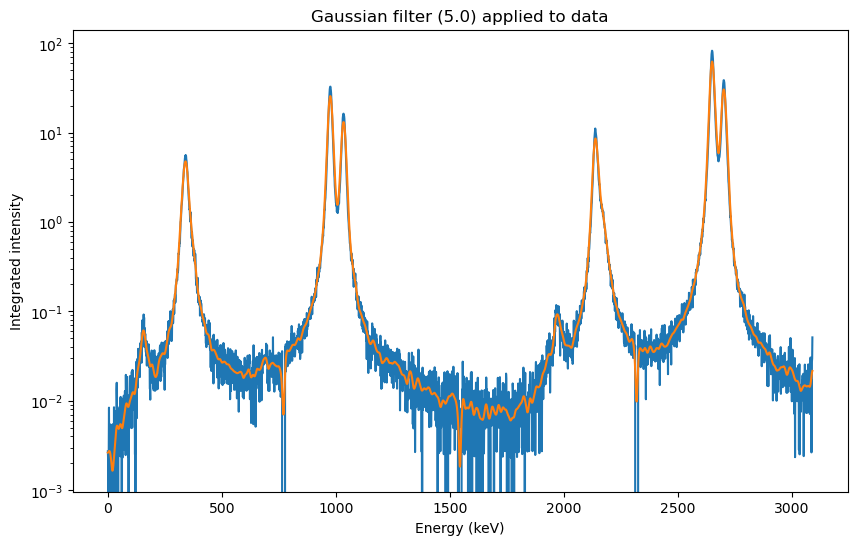

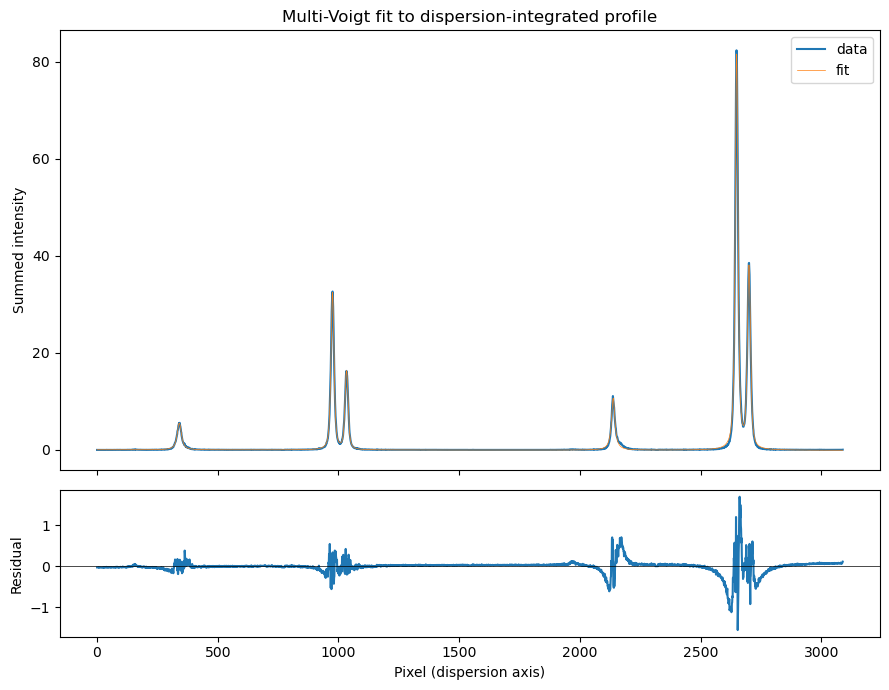

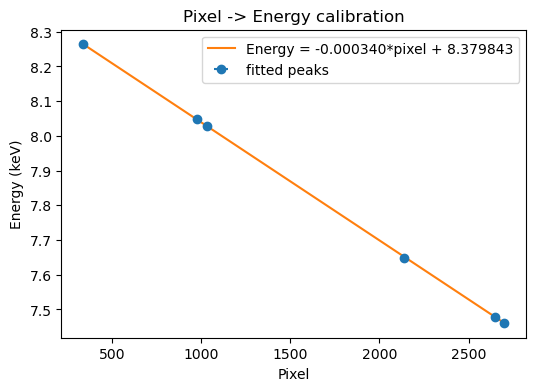

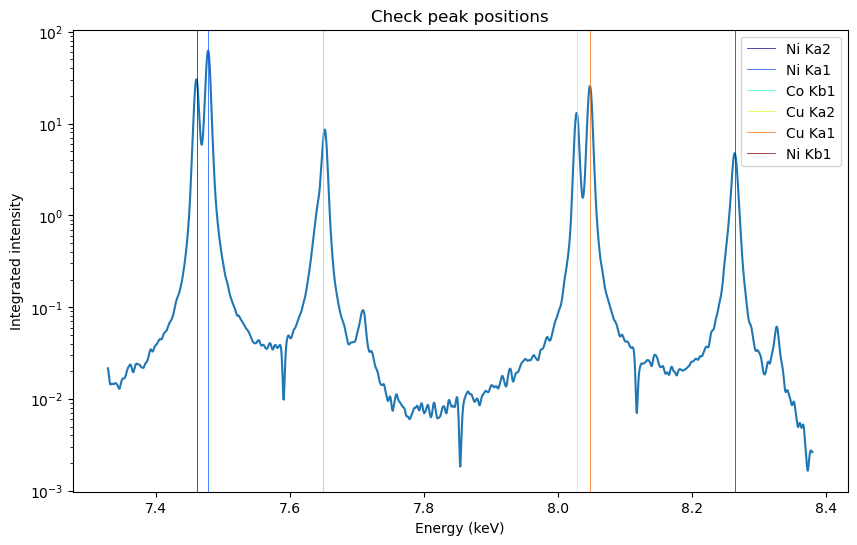

In [19]:
# Calculate the spatial axis conversion - result contains 'fitted_peaks': fitted_peaks, 'pixel_to_energy': pixel_to_energy, 'fit_full': fit_out
result = cal.calculate_spatial_energy_axis_conversion(peakenergies_input=peakenergies_array, dispersionmask_filepath=dispersionmask_savepath, gaussian_blur=5.0, plot=True)

In [20]:
# Resulting pixel - energy conversion
pixel_to_energy = result["pixel_to_energy"]
print(pixel_to_energy)

cal.save_pixel_to_energy(pixel_to_energy, save_dir=".")

{'slope_keV_per_px': -0.0003403296201908425, 'intercept_keV': 8.379842683843831}
✅ Calibration saved to ./pixel_to_energy_fssr1.json


In [ ]:
peakenergies_known = [6.404, 6.391]  # Fe Kα1, Kα2 lines in keV
calibration_result = cal.manual_peak_picker(peakenergies_known)